# 네이버 영화리뷰 감정분석 with DNN
참고 소스 출처(링크) : https://cyc1am3n.github.io/2018/11/10/classifying_korean_movie_review.html<br>
https://devtimes.com/nlp-korea-movie-review

# 준비
라이브러리, 파라미터 세팅

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
from konlpy.tag import Okt
import nltk
from tqdm import tqdm
import time
import json

import tensorflow as tf

In [2]:
DATA_IN_PATH = './data_in/'
DATA_OUT_PATH = './data_out/'

TEST_SIZE = 0.2
RANDOM_SEED = 42

# 데이터 로드

In [3]:
train_df = pd.read_csv("./data_in/ratings_train.txt", "\t")
test_df = pd.read_csv("./data_in/ratings_test.txt", "\t")

# 데이터 전처리
데이터를 학습 시키기 위해 전처리를 진행해야 하는데, Konlpy를 이용해 형태소 분석 및 품사 태깅을 수행한다.

영어의 경우 주어진 단어의 빈도만을 사용해서 처리해도 크게 문제는 없지만 한국어는 영어와는 달리 띄어쓰기로 의미를 구분짓기에는 한계가 있고, 리뷰 특성상 맞춤법이나 띄어쓰기가 제대로 되어있지 않는 경우가 있을 수 있기 때문에 정확한 분류를 위해서는 Konlpy를 이용하는 것이 좋다.

Konlpy는 띄어쓰기 알고리즘과 정규화를 이용해서 맞춤법이 틀린 문장도 어느 정도 고쳐주고, 형태소 분석과 품사를 태깅해주는 여러 클래스를 제공하고 있다.

In [4]:
okt = Okt()
okt.pos(u'흔들리는 꽃들 속에서 네 샴푸향이 느껴진거야')

[('흔들리는', 'Verb'),
 ('꽃', 'Noun'),
 ('들', 'Suffix'),
 ('속', 'Noun'),
 ('에서', 'Josa'),
 ('네', 'Noun'),
 ('샴푸', 'Noun'),
 ('향', 'Noun'),
 ('이', 'Josa'),
 ('느껴진거야', 'Verb')]

In [5]:
# 토크나이즈 함수 생성
def tokenize(doc):
    #형태소와 품사를 join
    return ['/'.join(t) for t in okt.pos(doc, norm=True, stem=True)]  # norm은 정규화, stem은 근어로 표시 수행

In [6]:
# 리뷰가 null인 경우 토크나이즈 함수에서 오류가 발생할 수 있으니 사전에 null값 확인해보고 빈문자열로 대체
train_df.isnull().any() #document에 null값이 있다.
train_df['document'] = train_df['document'].fillna(''); #null값을 ''값으로 대체

test_df.isnull().any()
test_df['document'] = test_df['document'].fillna(''); #null값을 ''값으로 대체

In [7]:
# start = time.time()  # 시작 시간 저장

# # 학습데이터와 테스트데이터를 분석하여 저장 (tokenize 과정은 시간이 오래 걸릴 수 있음)
# train_docs = [(tokenize(row[1]), row[2]) for row in train_df.values]
# test_docs = [(tokenize(row[1]), row[2]) for row in test_df.values]

# print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

In [8]:
start = time.time()  # 시작 시간 저장

# 학습 데이터 tokenize
train_docs = []
for row in tqdm(train_df.values):
    train_docs.append((tokenize(row[1]), row[2]))

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

100%|██████████| 150000/150000 [07:47<00:00, 320.54it/s]  

time : 467.97802209854126


In [9]:
start = time.time()  # 시작 시간 저장

# 테스트 데이터 tokenize
test_docs = []
for row in tqdm(test_df.values):
    test_docs.append((tokenize(row[1]), row[2]))

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

100%|██████████| 50000/50000 [03:10<00:00, 262.82it/s] 

time : 190.36151432991028


In [9]:
print(train_docs[0])
print(test_docs[0])

(['아/Exclamation', '더빙/Noun', '../Punctuation', '진짜/Noun', '짜증나다/Adjective', '목소리/Noun'], 0)
(['굳다/Adjective', 'ㅋ/KoreanParticle'], 1)


In [10]:
# 15만 학습데이터에서 분리된 토큰 개수 확인
tokens = [t for d in train_docs for t in d[0]]
print("토큰개수:", len(tokens))

토큰개수: 2159921


이제 이 데이터를 가지고 nltk를 이용해 전처리를 한다.<br>
Text 클래스는 문서를 편리하게 탐색할 수 있는 다양한 기능을 제공하고 있다.<br>
여기서는 vocab().most_common 매서드를 이용해 데이터가 가장 자주 사용되는 단어를 가져올 때 사용한다.

In [11]:
text = nltk.Text(tokens, name='NMSC')

#토큰개수
print(len(text.tokens))

#중복을 제외한 토큰개수
print(len(set(text.tokens)))

#출력빈도가 높은 상위 토큰 10개
print(text.vocab().most_common(10))

2159921
49894
[('./Punctuation', 67778), ('영화/Noun', 50818), ('하다/Verb', 41209), ('이/Josa', 38540), ('보다/Verb', 38538), ('의/Josa', 30188), ('../Punctuation', 29055), ('가/Josa', 26627), ('에/Josa', 26468), ('을/Josa', 23118)]


# 데이터 탐색(EDA)

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50689 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54868 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54616 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 45796 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 48372 missing from current font.
  font.set_

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 50689 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 54868 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 54616 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 45796 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 48372 missing from current font.
  font.set_text(s, 0,

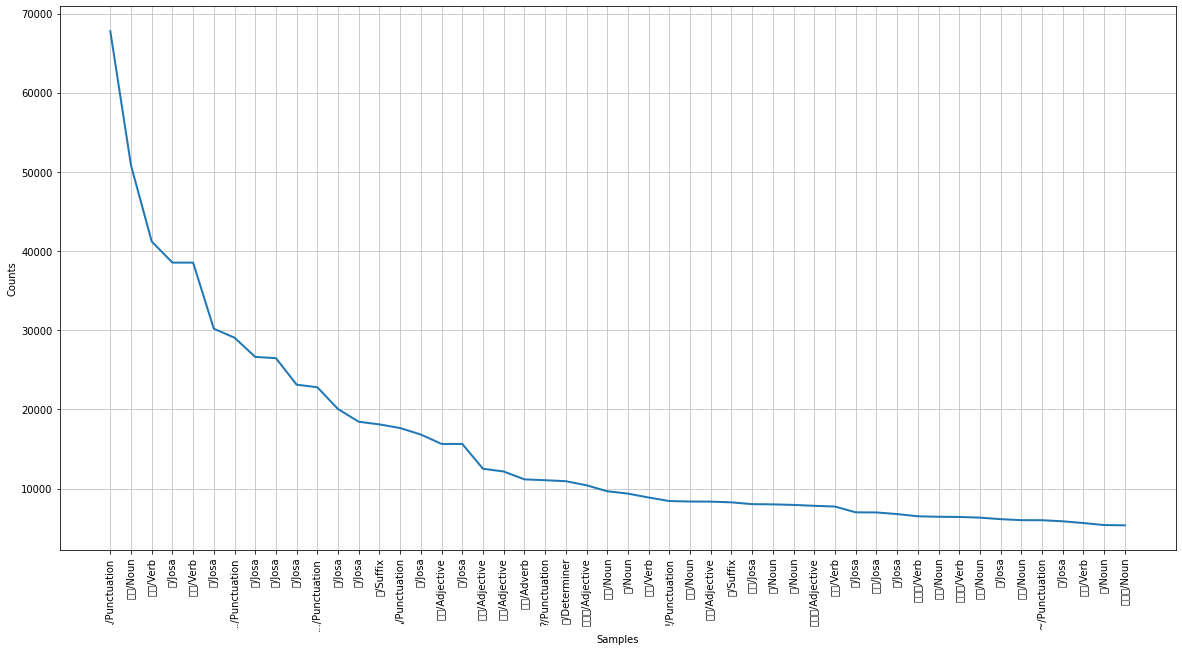

In [12]:
# 출력빈도가 높은 상위 토큰 10개를 matplotlib을 이용해 그래프로 확인
plt.figure(figsize=(20,10))
text.plot(50)

모델을 만들기 위해 벡터화를 해야 하는데, 자주 사용되는 토큰 10000개를 사용해 데이터를 백터화(원 핫 인코딩 대신 CountVectorization을 사용)

문서 집합에서 단어 토큰을 생성하고 각 단어의 수를 세어 BOW(Bag of Words) 인코딩한 벡터를 만드는 역할을 한다.

(시간이 오래 걸리므로 테스트 시 100개만 수행)

In [10]:
FREQUENCY_COUNT = 10000; # 시간적 여유가 있다면 10000개 수행(100개 성능 71% 정도, 10000개 성능 85% 정도)

In [14]:
selected_words = [f[0] for f in text.vocab().most_common(FREQUENCY_COUNT)]

In [15]:
# start = time.time()  # 시작 시간 저장

# selected_words = []
# for f in tqdm(text.vocab().most_common(FREQUENCY_COUNT)):
#     selected_words.append(f[0])

# print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

이 과정은 데이터 양이 큰 만큼 시간이 오래 걸리기 때문에 이 작업을 반복하지 않도록 태깅을 마친 후에는 json파일로 저장하는 것도 좋은 방법이다.

문서에서 상위로 선택된 단어들중 몇개가 포함이 되는지를 알아야 한다.

In [16]:
#단어리스트 문서에서 상위 10000개들중 포함되는 단어들이 개수
def term_frequency(doc):
    return [doc.count(word) for word in selected_words]

In [17]:
# start = time.time()  # 시작 시간 저장

# #문서에 들어가는 단어 개수
# x_train = [term_frequency(d) for d,_ in train_docs]
# x_test = [term_frequency(d) for d,_ in test_docs]

# print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

In [18]:
start = time.time()  # 시작 시간 저장

#문서에 들어가는 단어 개수
x_train = []
for d,_ in tqdm(train_docs):
    x_train.append(term_frequency(d))

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

100%|██████████| 150000/150000 [2:53:25<00:00, 14.42it/s]    

time : 10405.07530927658


In [19]:
start = time.time()  # 시작 시간 저장

#문서에 들어가는 단어 개수
x_test = []
for d,_ in tqdm(test_docs):
    x_test.append(term_frequency(d))

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

100%|██████████| 50000/50000 [3:01:48<00:00,  4.58it/s]     

time : 10908.027993917465


In [20]:
start = time.time()  # 시작 시간 저장

#라벨(1 or 0)
y_train = [c for _,c in train_docs]
y_test = [c for _,c in test_docs]

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

time : 0.05489826202392578


이렇게 하면 x축 데이터에는 단어들의 빈도수 정보, y축에는 분류 결과를 깔끔하게 정리할 수 있다.

이제 데이터를 float로 형 변환 시켜주면 데이터 전처리 과정은 끝이다.

In [29]:
x_train = np.asarray(x_train).astype('float32')
x_test = np.asarray(x_test).astype('float32')

y_train = np.asarray(y_train).astype('float32')
y_test = np.asarray(y_test).astype('float32')

# 테스트 데이터셋(캐글) 로드 및 전처리

In [11]:
# 테스트(캐글) 데이터 로드
real_test_df = pd.read_csv('./data_in/ko_data.csv', encoding='cp949')
real_test_df.columns = ['id','document']
real_test_df.head()

,id,document
0,0,정말 많이 울었던 영화입니다.
1,1,시간 낭비예요.
2,2,포스터를 저렇게밖에 만들지 못했던 제작자의 소심함에 침을 뱉고 싶다.
3,3,지금 봐도 재미있는 영화!!! 코믹과 감동!!! 그리고 요리!!!
4,4,이걸 영화로 만드는 거야?얼마나 가는지 보자.


In [12]:
# 리뷰가 null인 경우 토크나이즈 함수에서 오류가 발생할 수 있으니 사전에 null값 확인해보고 빈문자열로 대체
real_test_df.isnull().any()
real_test_df['document'] = real_test_df['document'].fillna(''); #null값을 ''값으로 대체

In [13]:
start = time.time()  # 시작 시간 저장

# 학습 데이터 tokenize
real_test_docs = []
for row in tqdm(real_test_df.values):
    real_test_docs.append((tokenize(row[1])))

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

100%|██████████| 11187/11187 [00:23<00:00, 484.25it/s]

time : 23.103659629821777


In [40]:
print(real_test_docs[0])

['정말/Noun', '많이/Adverb', '울다/Verb', '영화/Noun', '이다/Adjective', './Punctuation']


In [42]:
start = time.time()  # 시작 시간 저장

#문서에 들어가는 단어 개수
x_real_test = []
for d in tqdm(real_test_docs):
    x_real_test.append(term_frequency(d))

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

100%|██████████| 11187/11187 [00:32<00:00, 342.27it/s]

time : 32.68648290634155


In [43]:
# 단어들의 빈도수 정보 넣고 float로 형 변환
x_real_test = np.asarray(x_real_test).astype('float32')

# npy 파일 저장

In [44]:
DATA_IN_PATH = './data_in/'
TRAIN_INPUT_DATA = 'dnn_train_input.npy'
TRAIN_LABEL_DATA = 'dnn_train_label.npy'
DEV_INPUT_DATA = 'dnn_dev_input.npy'
DEV_LABEL_DATA = 'dnn_dev_label.npy'
TEST_INPUT_DATA = 'dnn_test_input.npy'
DATA_CONFIGS = 'dnn_vocab_configs.json'

data_configs = {}
data_configs['vocab'] = selected_words
data_configs['vocab_size'] = len(selected_words) # vocab size 추가

import os
# 저장하는 디렉토리가 존재하지 않으면 생성
if not os.path.exists(DATA_IN_PATH):
    os.makedirs(DATA_IN_PATH)

# 전처리 된 학습 데이터를 넘파이 형태로 저장
np.save(open(DATA_IN_PATH + TRAIN_INPUT_DATA, 'wb'), x_train)
np.save(open(DATA_IN_PATH + TRAIN_LABEL_DATA, 'wb'), y_train)
# 전처리 된 검증 데이터를 넘파이 형태로 저장
np.save(open(DATA_IN_PATH + DEV_INPUT_DATA, 'wb'), x_test)
np.save(open(DATA_IN_PATH + DEV_LABEL_DATA, 'wb'), y_test)
# 전처리 된 테스트 데이터를 넘파이 형태로 저장
np.save(open(DATA_IN_PATH + TEST_INPUT_DATA, 'wb'), x_real_test)

# 데이터 사전을 json 형태로 저장
json.dump(data_configs, open(DATA_IN_PATH + DATA_CONFIGS, 'w'), ensure_ascii=False)

# npy 파일 로드 - 재작업 시 여기부터 수행

In [14]:
DATA_IN_PATH = './data_in/'
TRAIN_INPUT_DATA = 'dnn_train_input.npy'
TRAIN_LABEL_DATA = 'dnn_train_label.npy'
DEV_INPUT_DATA = 'dnn_dev_input.npy'
DEV_LABEL_DATA = 'dnn_dev_label.npy'
TEST_INPUT_DATA = 'dnn_test_input.npy'
DATA_CONFIGS = 'dnn_vocab_configs.json'

x_train = np.load(open(DATA_IN_PATH + TRAIN_INPUT_DATA, 'rb'))
y_train = np.load(open(DATA_IN_PATH + TRAIN_LABEL_DATA, 'rb'))
x_test = np.load(open(DATA_IN_PATH + DEV_INPUT_DATA, 'rb'))
y_test = np.load(open(DATA_IN_PATH + DEV_LABEL_DATA, 'rb'))
x_real_test = np.load(open(DATA_IN_PATH + TEST_INPUT_DATA, 'rb'))
selected_words = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

# 모델 생성
텐서플로 케라스를 이용해 모델을 생성한다. 레이어 구성은 두개의 Dense층은 64개의 유닛을 가지고 활성함수는 relu를 사용하고, 마지막층은 sigmoid 활성화 함수를 사용해 긍정 리뷰일 확률을 출력한다.

In [15]:
#레이어 구성
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(FREQUENCY_COUNT,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

손실 함수는 binary_crossentropy, RMSprop 옵티마이저를 통해 경사하강법을 진행

In [16]:
# 재현율, 정밀도, F1-Score 성능 측정 함수
from keras import backend as K

# 재현율
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

# 정밀도
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

# F1-Score
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# # compile the model
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])

# # fit the model
# history = model.fit(Xtrain, ytrain, validation_split=0.3, epochs=10, verbose=0)

# # evaluate the model
# loss, accuracy, f1_score, precision, recall = model.evaluate(Xtest, ytest, verbose=0)

In [17]:
#학습 프로세스 설정
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.001),
    loss=tf.keras.losses.binary_crossentropy,
    #metrics=[tf.keras.metrics.binary_accuracy]
    metrics=[tf.keras.metrics.binary_accuracy,f1_m,precision_m, recall_m]
    )

배치 사이즈는 512, 에포크는 10번으로 학습을 시켜 모델을 만들어 본다.

In [18]:
#학습 데이터로 학습
model.fit(x_train, y_train, epochs=10, batch_size=512)

Epoch 1/10
293/293 [==============================] - 71s 241ms/step - loss: 0.3876 - binary_accuracy: 0.8336 - f1_m: 0.8287 - precision_m: 0.8412 - recall_m: 0.8210
Epoch 2/10
293/293 [==============================] - 54s 184ms/step - loss: 0.3167 - binary_accuracy: 0.8648 - f1_m: 0.8633 - precision_m: 0.8696 - recall_m: 0.8578
Epoch 3/10
293/293 [==============================] - 50s 170ms/step - loss: 0.2925 - binary_accuracy: 0.8776 - f1_m: 0.8765 - precision_m: 0.8821 - recall_m: 0.8716
Epoch 4/10
293/293 [==============================] - 51s 174ms/step - loss: 0.2731 - binary_accuracy: 0.8883 - f1_m: 0.8872 - precision_m: 0.8929 - recall_m: 0.8821
Epoch 5/10
293/293 [==============================] - 54s 183ms/step - loss: 0.2540 - binary_accuracy: 0.8982 - f1_m: 0.8973 - precision_m: 0.9023 - recall_m: 0.8927
Epoch 6/10
293/293 [==============================] - 53s 179ms/step - loss: 0.2350 - binary_accuracy: 0.9074 - f1_m: 0.9066 - precision_m: 0.9109 - recall_m: 0.9028
Epoc

# 모델 평가 - 검증 데이터셋(Original Test Dataset)
학습데이터를 이용해 모델 학습이 끝났다면 테스트 데이터를 가지고 모델을 평가해본다.

In [12]:
# results = model.evaluate(x_test, y_test)
# # 1563/1563 [==============================] - 3s 2ms/step - loss: 0.4044 - binary_accuracy: 0.8535

In [13]:
# # FREQUENCY_COUNT 100 설정 시 => loss: 0.5, acc: 0.7
# # FREQUENCY_COUNT 10000 설정 시 => [0.4043751060962677, 0.8535199761390686]
# results

In [14]:
# evaluate the model
loss, accuracy, f1_score, precision, recall = model.evaluate(x_test, y_test)

1563/1563 [==============================] - 4s 3ms/step - loss: 0.4001 - binary_accuracy: 0.8525 - f1_m: 0.8487 - precision_m: 0.8582 - recall_m: 0.8475


사용한 토큰수를 100개로 할 경우 71%, 10000개로 한다면 85%정도의 정확도 확인 가능

In [15]:
#모델 저장하기
model.save('./data_out/movie_review_model_dnn_token_10000.h5')

# 모델 불러오기
#from keras.models import load_model
#model = load_model('./data_out/movie_review_model_dnn.h5')

# (참고) 제출 파일 생성

In [19]:
preds = model.predict(x_real_test)

In [20]:
preds

array([[0.95838076],
       [0.00402827],
       [0.2384789 ],
       ...,
       [0.98856735],
       [0.95267457],
       [0.18148352]], dtype=float32)

In [21]:
start = time.time()

test_preds = []
for i, pred in enumerate(preds):
    result = 1 if pred > 0.5 else 0
    test_preds.append(result)
    print(str(i)+"번 인덱스 데이터 처리 완료 =>", pred, test_preds[i])

print("time : ", time.time() - start)

0번 인덱스 데이터 처리 완료 => [0.95838076] 1
1번 인덱스 데이터 처리 완료 => [0.00402827] 0
2번 인덱스 데이터 처리 완료 => [0.2384789] 0
3번 인덱스 데이터 처리 완료 => [0.9822766] 1
4번 인덱스 데이터 처리 완료 => [0.06754084] 0
5번 인덱스 데이터 처리 완료 => [0.9983815] 1
6번 인덱스 데이터 처리 완료 => [0.01975623] 0
7번 인덱스 데이터 처리 완료 => [0.961877] 1
8번 인덱스 데이터 처리 완료 => [0.06116451] 0
9번 인덱스 데이터 처리 완료 => [0.95921296] 1
10번 인덱스 데이터 처리 완료 => [0.9822504] 1
11번 인덱스 데이터 처리 완료 => [0.13271762] 0
12번 인덱스 데이터 처리 완료 => [0.01550538] 0
13번 인덱스 데이터 처리 완료 => [0.11390795] 0
14번 인덱스 데이터 처리 완료 => [0.01081624] 0
15번 인덱스 데이터 처리 완료 => [0.86034006] 1
16번 인덱스 데이터 처리 완료 => [0.9911997] 1
17번 인덱스 데이터 처리 완료 => [0.18670957] 0
18번 인덱스 데이터 처리 완료 => [0.81601405] 1
19번 인덱스 데이터 처리 완료 => [0.9893869] 1
20번 인덱스 데이터 처리 완료 => [0.9465019] 1
21번 인덱스 데이터 처리 완료 => [0.9859774] 1
22번 인덱스 데이터 처리 완료 => [0.98342264] 1
23번 인덱스 데이터 처리 완료 => [0.9764845] 1
24번 인덱스 데이터 처리 완료 => [0.07967301] 0
25번 인덱스 데이터 처리 완료 => [0.03083384] 0
26번 인덱스 데이터 처리 완료 => [0.44131958] 0
27번 인덱스 데이터 처리 완료 => [0.63900137] 1
28번 인덱스 데이터 처

571번 인덱스 데이터 처리 완료 => [0.9228154] 1
572번 인덱스 데이터 처리 완료 => [0.701757] 1
573번 인덱스 데이터 처리 완료 => [0.99623954] 1
574번 인덱스 데이터 처리 완료 => [0.9839408] 1
575번 인덱스 데이터 처리 완료 => [0.1878952] 0
576번 인덱스 데이터 처리 완료 => [0.00362654] 0
577번 인덱스 데이터 처리 완료 => [0.98595953] 1
578번 인덱스 데이터 처리 완료 => [0.9571812] 1
579번 인덱스 데이터 처리 완료 => [0.82343245] 1
580번 인덱스 데이터 처리 완료 => [0.04171043] 0
581번 인덱스 데이터 처리 완료 => [0.7764094] 1
582번 인덱스 데이터 처리 완료 => [0.9496386] 1
583번 인덱스 데이터 처리 완료 => [0.06228012] 0
584번 인덱스 데이터 처리 완료 => [0.10158873] 0
585번 인덱스 데이터 처리 완료 => [0.6424229] 1
586번 인덱스 데이터 처리 완료 => [0.15965465] 0
587번 인덱스 데이터 처리 완료 => [0.9371094] 1
588번 인덱스 데이터 처리 완료 => [0.01233757] 0
589번 인덱스 데이터 처리 완료 => [0.09405871] 0
590번 인덱스 데이터 처리 완료 => [0.27271482] 0
591번 인덱스 데이터 처리 완료 => [0.27271482] 0
592번 인덱스 데이터 처리 완료 => [0.96725655] 1
593번 인덱스 데이터 처리 완료 => [0.90780646] 1
594번 인덱스 데이터 처리 완료 => [0.9745077] 1
595번 인덱스 데이터 처리 완료 => [0.02626362] 0
596번 인덱스 데이터 처리 완료 => [0.9071494] 1
597번 인덱스 데이터 처리 완료 => [0.01402065] 0
598번 인덱스 데이터 

978번 인덱스 데이터 처리 완료 => [0.9956773] 1
979번 인덱스 데이터 처리 완료 => [0.89080554] 1
980번 인덱스 데이터 처리 완료 => [0.74347574] 1
981번 인덱스 데이터 처리 완료 => [0.9427684] 1
982번 인덱스 데이터 처리 완료 => [0.9838626] 1
983번 인덱스 데이터 처리 완료 => [0.02444917] 0
984번 인덱스 데이터 처리 완료 => [0.9573263] 1
985번 인덱스 데이터 처리 완료 => [0.27836025] 0
986번 인덱스 데이터 처리 완료 => [0.00013647] 0
987번 인덱스 데이터 처리 완료 => [0.00899559] 0
988번 인덱스 데이터 처리 완료 => [0.01174786] 0
989번 인덱스 데이터 처리 완료 => [0.95737904] 1
990번 인덱스 데이터 처리 완료 => [0.40801108] 0
991번 인덱스 데이터 처리 완료 => [0.48311433] 0
992번 인덱스 데이터 처리 완료 => [0.03446136] 0
993번 인덱스 데이터 처리 완료 => [0.8639002] 1
994번 인덱스 데이터 처리 완료 => [0.9436943] 1
995번 인덱스 데이터 처리 완료 => [0.93741864] 1
996번 인덱스 데이터 처리 완료 => [0.9200855] 1
997번 인덱스 데이터 처리 완료 => [0.93591094] 1
998번 인덱스 데이터 처리 완료 => [0.00358007] 0
999번 인덱스 데이터 처리 완료 => [0.43768117] 0
1000번 인덱스 데이터 처리 완료 => [0.0174312] 0
1001번 인덱스 데이터 처리 완료 => [0.9269273] 1
1002번 인덱스 데이터 처리 완료 => [0.9515709] 1
1003번 인덱스 데이터 처리 완료 => [0.98702186] 1
1004번 인덱스 데이터 처리 완료 => [0.8664865] 1
1005번 인

1600번 인덱스 데이터 처리 완료 => [0.88308334] 1
1601번 인덱스 데이터 처리 완료 => [0.88756126] 1
1602번 인덱스 데이터 처리 완료 => [0.94150656] 1
1603번 인덱스 데이터 처리 완료 => [0.9974137] 1
1604번 인덱스 데이터 처리 완료 => [0.00327423] 0
1605번 인덱스 데이터 처리 완료 => [0.19434135] 0
1606번 인덱스 데이터 처리 완료 => [0.51305073] 1
1607번 인덱스 데이터 처리 완료 => [0.02579602] 0
1608번 인덱스 데이터 처리 완료 => [0.9497912] 1
1609번 인덱스 데이터 처리 완료 => [0.9966294] 1
1610번 인덱스 데이터 처리 완료 => [0.65854645] 1
1611번 인덱스 데이터 처리 완료 => [0.22193031] 0
1612번 인덱스 데이터 처리 완료 => [0.35165396] 0
1613번 인덱스 데이터 처리 완료 => [0.2591662] 0
1614번 인덱스 데이터 처리 완료 => [0.31135675] 0
1615번 인덱스 데이터 처리 완료 => [0.10075548] 0
1616번 인덱스 데이터 처리 완료 => [0.00493211] 0
1617번 인덱스 데이터 처리 완료 => [0.937298] 1
1618번 인덱스 데이터 처리 완료 => [0.10108377] 0
1619번 인덱스 데이터 처리 완료 => [0.00132771] 0
1620번 인덱스 데이터 처리 완료 => [0.5437725] 1
1621번 인덱스 데이터 처리 완료 => [0.96880305] 1
1622번 인덱스 데이터 처리 완료 => [0.99176437] 1
1623번 인덱스 데이터 처리 완료 => [0.9989347] 1
1624번 인덱스 데이터 처리 완료 => [0.04575139] 0
1625번 인덱스 데이터 처리 완료 => [0.00080163] 0
1626번 인덱스 데이터 처리 완료 

2464번 인덱스 데이터 처리 완료 => [0.06760144] 0
2465번 인덱스 데이터 처리 완료 => [0.04702394] 0
2466번 인덱스 데이터 처리 완료 => [0.92119783] 1
2467번 인덱스 데이터 처리 완료 => [0.8662414] 1
2468번 인덱스 데이터 처리 완료 => [0.02408489] 0
2469번 인덱스 데이터 처리 완료 => [0.00721195] 0
2470번 인덱스 데이터 처리 완료 => [0.05056535] 0
2471번 인덱스 데이터 처리 완료 => [0.5582763] 1
2472번 인덱스 데이터 처리 완료 => [0.02432742] 0
2473번 인덱스 데이터 처리 완료 => [0.02354081] 0
2474번 인덱스 데이터 처리 완료 => [0.26281965] 0
2475번 인덱스 데이터 처리 완료 => [0.00408375] 0
2476번 인덱스 데이터 처리 완료 => [0.00697497] 0
2477번 인덱스 데이터 처리 완료 => [0.00241649] 0
2478번 인덱스 데이터 처리 완료 => [0.52190334] 1
2479번 인덱스 데이터 처리 완료 => [0.03577304] 0
2480번 인덱스 데이터 처리 완료 => [0.02575359] 0
2481번 인덱스 데이터 처리 완료 => [0.0231419] 0
2482번 인덱스 데이터 처리 완료 => [0.9100034] 1
2483번 인덱스 데이터 처리 완료 => [0.9772095] 1
2484번 인덱스 데이터 처리 완료 => [0.02301965] 0
2485번 인덱스 데이터 처리 완료 => [0.01814575] 0
2486번 인덱스 데이터 처리 완료 => [0.11480875] 0
2487번 인덱스 데이터 처리 완료 => [0.9459181] 1
2488번 인덱스 데이터 처리 완료 => [0.9445395] 1
2489번 인덱스 데이터 처리 완료 => [0.51305073] 1
2490번 인덱스 데이터 처리 완료

3200번 인덱스 데이터 처리 완료 => [0.9633698] 1
3201번 인덱스 데이터 처리 완료 => [0.37322983] 0
3202번 인덱스 데이터 처리 완료 => [0.9722724] 1
3203번 인덱스 데이터 처리 완료 => [0.09867113] 0
3204번 인덱스 데이터 처리 완료 => [0.11421274] 0
3205번 인덱스 데이터 처리 완료 => [0.994795] 1
3206번 인덱스 데이터 처리 완료 => [0.04255252] 0
3207번 인덱스 데이터 처리 완료 => [0.01892974] 0
3208번 인덱스 데이터 처리 완료 => [0.09568063] 0
3209번 인덱스 데이터 처리 완료 => [0.13257042] 0
3210번 인덱스 데이터 처리 완료 => [0.00142236] 0
3211번 인덱스 데이터 처리 완료 => [0.61904645] 1
3212번 인덱스 데이터 처리 완료 => [0.99289286] 1
3213번 인덱스 데이터 처리 완료 => [0.11411413] 0
3214번 인덱스 데이터 처리 완료 => [0.19370702] 0
3215번 인덱스 데이터 처리 완료 => [0.81851864] 1
3216번 인덱스 데이터 처리 완료 => [0.7531951] 1
3217번 인덱스 데이터 처리 완료 => [0.96678627] 1
3218번 인덱스 데이터 처리 완료 => [0.76062936] 1
3219번 인덱스 데이터 처리 완료 => [0.7758661] 1
3220번 인덱스 데이터 처리 완료 => [0.94195354] 1
3221번 인덱스 데이터 처리 완료 => [0.8410293] 1
3222번 인덱스 데이터 처리 완료 => [0.00866915] 0
3223번 인덱스 데이터 처리 완료 => [0.11564647] 0
3224번 인덱스 데이터 처리 완료 => [0.99112743] 1
3225번 인덱스 데이터 처리 완료 => [0.0778348] 0
3226번 인덱스 데이터 처리 완료 

3942번 인덱스 데이터 처리 완료 => [0.04183157] 0
3943번 인덱스 데이터 처리 완료 => [0.09504789] 0
3944번 인덱스 데이터 처리 완료 => [0.02617188] 0
3945번 인덱스 데이터 처리 완료 => [0.03902809] 0
3946번 인덱스 데이터 처리 완료 => [0.9918675] 1
3947번 인덱스 데이터 처리 완료 => [0.9445535] 1
3948번 인덱스 데이터 처리 완료 => [0.9320128] 1
3949번 인덱스 데이터 처리 완료 => [0.99930537] 1
3950번 인덱스 데이터 처리 완료 => [0.99314886] 1
3951번 인덱스 데이터 처리 완료 => [0.62292343] 1
3952번 인덱스 데이터 처리 완료 => [0.00673746] 0
3953번 인덱스 데이터 처리 완료 => [0.00636361] 0
3954번 인덱스 데이터 처리 완료 => [0.9436606] 1
3955번 인덱스 데이터 처리 완료 => [0.15526444] 0
3956번 인덱스 데이터 처리 완료 => [0.6842452] 1
3957번 인덱스 데이터 처리 완료 => [0.04353535] 0
3958번 인덱스 데이터 처리 완료 => [0.99944466] 1
3959번 인덱스 데이터 처리 완료 => [0.9754945] 1
3960번 인덱스 데이터 처리 완료 => [0.01950711] 0
3961번 인덱스 데이터 처리 완료 => [0.0023795] 0
3962번 인덱스 데이터 처리 완료 => [0.10964082] 0
3963번 인덱스 데이터 처리 완료 => [0.86064994] 1
3964번 인덱스 데이터 처리 완료 => [0.00088504] 0
3965번 인덱스 데이터 처리 완료 => [0.92098737] 1
3966번 인덱스 데이터 처리 완료 => [0.99847513] 1
3967번 인덱스 데이터 처리 완료 => [0.777774] 1
3968번 인덱스 데이터 처리 완료 =

4889번 인덱스 데이터 처리 완료 => [0.03327184] 0
4890번 인덱스 데이터 처리 완료 => [0.01415366] 0
4891번 인덱스 데이터 처리 완료 => [0.8422107] 1
4892번 인덱스 데이터 처리 완료 => [0.04692627] 0
4893번 인덱스 데이터 처리 완료 => [0.35910007] 0
4894번 인덱스 데이터 처리 완료 => [0.7583505] 1
4895번 인덱스 데이터 처리 완료 => [0.17748553] 0
4896번 인덱스 데이터 처리 완료 => [0.93040687] 1
4897번 인덱스 데이터 처리 완료 => [0.01269053] 0
4898번 인덱스 데이터 처리 완료 => [0.70458287] 1
4899번 인덱스 데이터 처리 완료 => [0.0589079] 0
4900번 인덱스 데이터 처리 완료 => [0.9252443] 1
4901번 인덱스 데이터 처리 완료 => [0.02404364] 0
4902번 인덱스 데이터 처리 완료 => [0.03236843] 0
4903번 인덱스 데이터 처리 완료 => [0.0008992] 0
4904번 인덱스 데이터 처리 완료 => [0.994905] 1
4905번 인덱스 데이터 처리 완료 => [0.39777368] 0
4906번 인덱스 데이터 처리 완료 => [0.9242811] 1
4907번 인덱스 데이터 처리 완료 => [0.06353804] 0
4908번 인덱스 데이터 처리 완료 => [0.9706872] 1
4909번 인덱스 데이터 처리 완료 => [0.9962387] 1
4910번 인덱스 데이터 처리 완료 => [0.02344807] 0
4911번 인덱스 데이터 처리 완료 => [0.9912668] 1
4912번 인덱스 데이터 처리 완료 => [0.9866128] 1
4913번 인덱스 데이터 처리 완료 => [0.89494085] 1
4914번 인덱스 데이터 처리 완료 => [0.51305073] 1
4915번 인덱스 데이터 처리 완료 => [

5616번 인덱스 데이터 처리 완료 => [0.9995914] 1
5617번 인덱스 데이터 처리 완료 => [0.00019092] 0
5618번 인덱스 데이터 처리 완료 => [0.15387097] 0
5619번 인덱스 데이터 처리 완료 => [0.99433905] 1
5620번 인덱스 데이터 처리 완료 => [0.51773995] 1
5621번 인덱스 데이터 처리 완료 => [0.41763377] 0
5622번 인덱스 데이터 처리 완료 => [0.06104797] 0
5623번 인덱스 데이터 처리 완료 => [0.9993641] 1
5624번 인덱스 데이터 처리 완료 => [0.8984852] 1
5625번 인덱스 데이터 처리 완료 => [0.13006896] 0
5626번 인덱스 데이터 처리 완료 => [0.9988279] 1
5627번 인덱스 데이터 처리 완료 => [0.9956851] 1
5628번 인덱스 데이터 처리 완료 => [0.7583505] 1
5629번 인덱스 데이터 처리 완료 => [0.9804936] 1
5630번 인덱스 데이터 처리 완료 => [0.03186248] 0
5631번 인덱스 데이터 처리 완료 => [0.11675282] 0
5632번 인덱스 데이터 처리 완료 => [0.05471366] 0
5633번 인덱스 데이터 처리 완료 => [0.8722109] 1
5634번 인덱스 데이터 처리 완료 => [0.95961577] 1
5635번 인덱스 데이터 처리 완료 => [0.9598661] 1
5636번 인덱스 데이터 처리 완료 => [0.00818544] 0
5637번 인덱스 데이터 처리 완료 => [0.75286305] 1
5638번 인덱스 데이터 처리 완료 => [0.8295002] 1
5639번 인덱스 데이터 처리 완료 => [0.99832374] 1
5640번 인덱스 데이터 처리 완료 => [0.8833152] 1
5641번 인덱스 데이터 처리 완료 => [0.8233927] 1
5642번 인덱스 데이터 처리 완료 => [

6572번 인덱스 데이터 처리 완료 => [0.00984471] 0
6573번 인덱스 데이터 처리 완료 => [0.3932478] 0
6574번 인덱스 데이터 처리 완료 => [0.37374973] 0
6575번 인덱스 데이터 처리 완료 => [0.7910223] 1
6576번 인덱스 데이터 처리 완료 => [0.23562108] 0
6577번 인덱스 데이터 처리 완료 => [0.0072609] 0
6578번 인덱스 데이터 처리 완료 => [0.05225913] 0
6579번 인덱스 데이터 처리 완료 => [0.081491] 0
6580번 인덱스 데이터 처리 완료 => [0.0133405] 0
6581번 인덱스 데이터 처리 완료 => [0.07962991] 0
6582번 인덱스 데이터 처리 완료 => [0.00520656] 0
6583번 인덱스 데이터 처리 완료 => [0.9628208] 1
6584번 인덱스 데이터 처리 완료 => [0.00172182] 0
6585번 인덱스 데이터 처리 완료 => [0.9811383] 1
6586번 인덱스 데이터 처리 완료 => [0.01109628] 0
6587번 인덱스 데이터 처리 완료 => [0.9994727] 1
6588번 인덱스 데이터 처리 완료 => [0.02510344] 0
6589번 인덱스 데이터 처리 완료 => [0.18014465] 0
6590번 인덱스 데이터 처리 완료 => [0.11553528] 0
6591번 인덱스 데이터 처리 완료 => [0.966703] 1
6592번 인덱스 데이터 처리 완료 => [0.04817942] 0
6593번 인덱스 데이터 처리 완료 => [0.0914138] 0
6594번 인덱스 데이터 처리 완료 => [0.01705983] 0
6595번 인덱스 데이터 처리 완료 => [0.9878108] 1
6596번 인덱스 데이터 처리 완료 => [0.9952219] 1
6597번 인덱스 데이터 처리 완료 => [0.9434402] 1
6598번 인덱스 데이터 처리 완료 => [0.5

7411번 인덱스 데이터 처리 완료 => [0.0045697] 0
7412번 인덱스 데이터 처리 완료 => [0.00640973] 0
7413번 인덱스 데이터 처리 완료 => [0.17115116] 0
7414번 인덱스 데이터 처리 완료 => [0.9683348] 1
7415번 인덱스 데이터 처리 완료 => [0.11588429] 0
7416번 인덱스 데이터 처리 완료 => [0.17029487] 0
7417번 인덱스 데이터 처리 완료 => [0.6523609] 1
7418번 인덱스 데이터 처리 완료 => [0.01335177] 0
7419번 인덱스 데이터 처리 완료 => [0.08025722] 0
7420번 인덱스 데이터 처리 완료 => [0.0849885] 0
7421번 인덱스 데이터 처리 완료 => [0.92808545] 1
7422번 인덱스 데이터 처리 완료 => [0.9927456] 1
7423번 인덱스 데이터 처리 완료 => [0.03533558] 0
7424번 인덱스 데이터 처리 완료 => [0.98306274] 1
7425번 인덱스 데이터 처리 완료 => [0.783911] 1
7426번 인덱스 데이터 처리 완료 => [0.29538205] 0
7427번 인덱스 데이터 처리 완료 => [0.03569725] 0
7428번 인덱스 데이터 처리 완료 => [0.23027098] 0
7429번 인덱스 데이터 처리 완료 => [0.9733374] 1
7430번 인덱스 데이터 처리 완료 => [0.9967282] 1
7431번 인덱스 데이터 처리 완료 => [0.6033014] 1
7432번 인덱스 데이터 처리 완료 => [0.47899967] 0
7433번 인덱스 데이터 처리 완료 => [0.98023903] 1
7434번 인덱스 데이터 처리 완료 => [0.15873684] 0
7435번 인덱스 데이터 처리 완료 => [0.93643624] 1
7436번 인덱스 데이터 처리 완료 => [0.9302579] 1
7437번 인덱스 데이터 처리 완료 => 

7980번 인덱스 데이터 처리 완료 => [0.87109405] 1
7981번 인덱스 데이터 처리 완료 => [0.9948931] 1
7982번 인덱스 데이터 처리 완료 => [0.9940355] 1
7983번 인덱스 데이터 처리 완료 => [0.98288065] 1
7984번 인덱스 데이터 처리 완료 => [0.00171139] 0
7985번 인덱스 데이터 처리 완료 => [0.28662586] 0
7986번 인덱스 데이터 처리 완료 => [0.94212514] 1
7987번 인덱스 데이터 처리 완료 => [0.9450282] 1
7988번 인덱스 데이터 처리 완료 => [0.01651249] 0
7989번 인덱스 데이터 처리 완료 => [0.99624914] 1
7990번 인덱스 데이터 처리 완료 => [0.7619565] 1
7991번 인덱스 데이터 처리 완료 => [0.94185513] 1
7992번 인덱스 데이터 처리 완료 => [0.98039186] 1
7993번 인덱스 데이터 처리 완료 => [0.96477723] 1
7994번 인덱스 데이터 처리 완료 => [0.04702394] 0
7995번 인덱스 데이터 처리 완료 => [0.53585625] 1
7996번 인덱스 데이터 처리 완료 => [0.8717962] 1
7997번 인덱스 데이터 처리 완료 => [0.08547463] 0
7998번 인덱스 데이터 처리 완료 => [0.07368743] 0
7999번 인덱스 데이터 처리 완료 => [0.08317358] 0
8000번 인덱스 데이터 처리 완료 => [0.15913227] 0
8001번 인덱스 데이터 처리 완료 => [0.01192019] 0
8002번 인덱스 데이터 처리 완료 => [0.9584242] 1
8003번 인덱스 데이터 처리 완료 => [0.10209271] 0
8004번 인덱스 데이터 처리 완료 => [0.01120304] 0
8005번 인덱스 데이터 처리 완료 => [0.92497003] 1
8006번 인덱스 데이터 처리 완

9006번 인덱스 데이터 처리 완료 => [0.72305226] 1
9007번 인덱스 데이터 처리 완료 => [0.95896155] 1
9008번 인덱스 데이터 처리 완료 => [0.05826859] 0
9009번 인덱스 데이터 처리 완료 => [0.9931444] 1
9010번 인덱스 데이터 처리 완료 => [0.10477436] 0
9011번 인덱스 데이터 처리 완료 => [0.9290858] 1
9012번 인덱스 데이터 처리 완료 => [0.00109684] 0
9013번 인덱스 데이터 처리 완료 => [0.00103024] 0
9014번 인덱스 데이터 처리 완료 => [0.0186001] 0
9015번 인덱스 데이터 처리 완료 => [0.9824675] 1
9016번 인덱스 데이터 처리 완료 => [0.9356242] 1
9017번 인덱스 데이터 처리 완료 => [0.24093331] 0
9018번 인덱스 데이터 처리 완료 => [0.965345] 1
9019번 인덱스 데이터 처리 완료 => [0.01873692] 0
9020번 인덱스 데이터 처리 완료 => [0.9808265] 1
9021번 인덱스 데이터 처리 완료 => [0.31266716] 0
9022번 인덱스 데이터 처리 완료 => [0.95664066] 1
9023번 인덱스 데이터 처리 완료 => [0.5073893] 1
9024번 인덱스 데이터 처리 완료 => [0.09413812] 0
9025번 인덱스 데이터 처리 완료 => [0.02035505] 0
9026번 인덱스 데이터 처리 완료 => [0.91987735] 1
9027번 인덱스 데이터 처리 완료 => [0.99950624] 1
9028번 인덱스 데이터 처리 완료 => [0.9411922] 1
9029번 인덱스 데이터 처리 완료 => [0.05496721] 0
9030번 인덱스 데이터 처리 완료 => [0.99051267] 1
9031번 인덱스 데이터 처리 완료 => [0.98744154] 1
9032번 인덱스 데이터 처리 완료 =>

10126번 인덱스 데이터 처리 완료 => [0.9872572] 1
10127번 인덱스 데이터 처리 완료 => [0.9514669] 1
10128번 인덱스 데이터 처리 완료 => [0.04490297] 0
10129번 인덱스 데이터 처리 완료 => [0.06230632] 0
10130번 인덱스 데이터 처리 완료 => [0.98467904] 1
10131번 인덱스 데이터 처리 완료 => [0.97872305] 1
10132번 인덱스 데이터 처리 완료 => [0.99267334] 1
10133번 인덱스 데이터 처리 완료 => [0.9859883] 1
10134번 인덱스 데이터 처리 완료 => [0.73650616] 1
10135번 인덱스 데이터 처리 완료 => [0.5529638] 1
10136번 인덱스 데이터 처리 완료 => [0.9991757] 1
10137번 인덱스 데이터 처리 완료 => [0.992353] 1
10138번 인덱스 데이터 처리 완료 => [0.8699497] 1
10139번 인덱스 데이터 처리 완료 => [0.9305431] 1
10140번 인덱스 데이터 처리 완료 => [0.995926] 1
10141번 인덱스 데이터 처리 완료 => [0.9524182] 1
10142번 인덱스 데이터 처리 완료 => [0.8910153] 1
10143번 인덱스 데이터 처리 완료 => [0.04643279] 0
10144번 인덱스 데이터 처리 완료 => [0.14848319] 0
10145번 인덱스 데이터 처리 완료 => [0.0084839] 0
10146번 인덱스 데이터 처리 완료 => [0.06216339] 0
10147번 인덱스 데이터 처리 완료 => [0.01343556] 0
10148번 인덱스 데이터 처리 완료 => [0.6645422] 1
10149번 인덱스 데이터 처리 완료 => [0.9847681] 1
10150번 인덱스 데이터 처리 완료 => [0.11083611] 0
10151번 인덱스 데이터 처리 완료 => [0.00835789] 0
10

11129번 인덱스 데이터 처리 완료 => [0.961465] 1
11130번 인덱스 데이터 처리 완료 => [0.8941792] 1
11131번 인덱스 데이터 처리 완료 => [0.9896576] 1
11132번 인덱스 데이터 처리 완료 => [0.01967025] 0
11133번 인덱스 데이터 처리 완료 => [0.19099464] 0
11134번 인덱스 데이터 처리 완료 => [5.5143042e-05] 0
11135번 인덱스 데이터 처리 완료 => [0.0197485] 0
11136번 인덱스 데이터 처리 완료 => [0.52396435] 1
11137번 인덱스 데이터 처리 완료 => [0.99120015] 1
11138번 인덱스 데이터 처리 완료 => [0.35874075] 0
11139번 인덱스 데이터 처리 완료 => [0.9742321] 1
11140번 인덱스 데이터 처리 완료 => [0.8943488] 1
11141번 인덱스 데이터 처리 완료 => [0.9956512] 1
11142번 인덱스 데이터 처리 완료 => [0.97242844] 1
11143번 인덱스 데이터 처리 완료 => [0.12297369] 0
11144번 인덱스 데이터 처리 완료 => [0.9598989] 1
11145번 인덱스 데이터 처리 완료 => [0.9561993] 1
11146번 인덱스 데이터 처리 완료 => [0.3620192] 0
11147번 인덱스 데이터 처리 완료 => [0.8576679] 1
11148번 인덱스 데이터 처리 완료 => [0.13686469] 0
11149번 인덱스 데이터 처리 완료 => [0.02904364] 0
11150번 인덱스 데이터 처리 완료 => [0.81352013] 1
11151번 인덱스 데이터 처리 완료 => [0.2840118] 0
11152번 인덱스 데이터 처리 완료 => [0.04974321] 0
11153번 인덱스 데이터 처리 완료 => [0.12771629] 0
11154번 인덱스 데이터 처리 완료 => [0.9993345]

In [22]:
# 테스트 데이터의 리뷰 부분을 리스트 처리
test_id = list(real_test_df['id'])

# 데이터프레임으로 데이터 구성하여 output에 투입
output = pd.DataFrame( data={"Id": test_id, "Predicted": test_preds} )
output.head()

,Id,Predicted
0,0,1
1,1,0
2,2,0
3,3,1
4,4,0


In [24]:
import os

# 해당 경로가 없으면 생성
if not os.path.exists(DATA_OUT_PATH):
    os.makedirs(DATA_OUT_PATH)

# csv파일로 만든다
output.to_csv(DATA_OUT_PATH + "NSMC_DNN.csv", index = False)  # 앙상블 조합 및 캐글 제출 용도

### 캐글 제출 결과
**[2020.12.20]**<br>
0.84766

# (참고) 입력 문장 긍/부정 예측하기
이제 리뷰 문자열을 받아 바로 결과를 예측하는 함수를 만들어 본다.

데이터 형태를 맞추기 위해 np.expand_dims 매서드를 이용해 array의 축을 확장 시켜주어야 한다.

최종 확률이 0.5 이상이면 긍정, 그렇지 않으면 부정이라고 예측한다.

In [59]:
review = "아주 재미 있어요"
token = tokenize(review)
token

['아주/Noun', '재미/Noun', '있다/Adjective']

In [60]:
tf = term_frequency(token)

In [61]:
data = np.expand_dims(np.asarray(tf).astype('float32'), axis=0)

In [62]:
float(model.predict(data))

0.9707552790641785

In [63]:
# 테스트한 로직을 함수화해서 사용
def predict_review(review):
    token = tokenize(review)
    tfq = term_frequency(token)
    data = np.expand_dims(np.asarray(tfq).astype('float32'), axis=0)
    score = float(model.predict(data))
    if(score > 0.5):
        print(f"{review} ==> 긍정({round(score*100)}%)")
    else:
        print(f"{review} ==> 부정({round((1-score)*100)}%)")

In [64]:
predict_review("재미 정말 없어요")

재미 정말 없어요 ==> 부정(96%)
